In [106]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score, precision_score, recall_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time


%matplotlib inline

In [89]:
data=pd.read_csv("../input/sgemm/sgemm_product.csv")
data.head()
#take average of 4 run
data["run_avg"]=np.mean(data.iloc[:,14:18],axis=1)

mean_run=np.mean(data["run_avg"])
print(mean_run)

#Binary Classification run_avg>mean_run
data["run_class"]=np.where(data['run_avg']>=mean_run, 1, 0)
data.groupby("run_class").size()

data.describe()

217.571953093958


,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms),run_avg,run_class
count,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000
mean,80.415364,80.415364,25.513113,13.935894,13.935894,17.371126,17.371126,5.000000,2.448609,2.448609,0.500000,0.500000,0.500000,0.500000,217.647852,217.579536,217.532756,217.527669,217.571953,0.261370
std,42.469220,42.469220,7.855619,7.873662,7.873662,9.389418,9.389418,3.000006,1.953759,1.953759,0.500001,0.500001,0.500001,0.500001,369.012422,368.677309,368.655118,368.677413,368.750161,0.439382
min,16.000000,16.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.290000,13.250000,13.360000,13.370000,13.317500,0.000000
25%,32.000000,32.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,40.660000,40.710000,40.660000,40.640000,40.667500,0.000000
50%,64.000000,64.000000,32.000000,8.000000,8.000000,16.000000,16.000000,5.000000,2.000000,2.000000,0.500000,0.500000,0.500000,0.500000,69.825000,69.930000,69.790000,69.820000,69.790000,0.000000
75%,128.000000,128.000000,32.000000,16.000000,16.000000,32.000000,32.000000,8.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,228.530000,228.310000,228.320000,228.320000,228.387500,1.000000
max,128.000000,128.000000,32.000000,32.000000,32.000000,32.000000,32.000000,8.000000,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000,3339.630000,3375.420000,3397.080000,3361.710000,3341.507500,1.000000


In [90]:
sgemm_df=data.drop(columns=['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)','run_avg'])
sgemm_df.to_csv(r'segmm_product_classification.csv')
sgemm_df.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,run_class
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,0
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,0
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,0
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,0
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,0


In [91]:
#data info
sgemm_df.info()
#No null values in the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241600 entries, 0 to 241599
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   MWG        241600 non-null  int64
 1   NWG        241600 non-null  int64
 2   KWG        241600 non-null  int64
 3   MDIMC      241600 non-null  int64
 4   NDIMC      241600 non-null  int64
 5   MDIMA      241600 non-null  int64
 6   NDIMB      241600 non-null  int64
 7   KWI        241600 non-null  int64
 8   VWM        241600 non-null  int64
 9   VWN        241600 non-null  int64
 10  STRM       241600 non-null  int64
 11  STRN       241600 non-null  int64
 12  SA         241600 non-null  int64
 13  SB         241600 non-null  int64
 14  run_class  241600 non-null  int64
dtypes: int64(15)
memory usage: 27.6 MB


In [92]:
#Varibale and predictor
y=np.array(sgemm_df["run_class"])

X=np.array(sgemm_df.iloc[:,0:14])


# PCA

[4.53639997e-01 4.52928645e-01 2.52855826e-02 2.10774165e-02
 1.72858772e-02 1.71234688e-02 8.64408260e-03 2.25738761e-03
 7.53872687e-04 7.52849140e-04 6.27052115e-05 6.27052115e-05
 6.27052115e-05 6.27052115e-05]


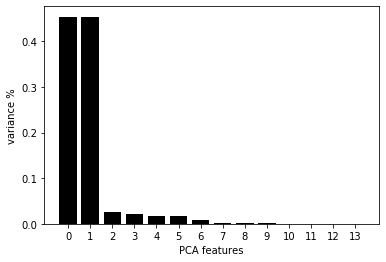

In [93]:
# Create a PCA instance: pca
pca = PCA(n_components=14)
principalComponents = pca.fit_transform(X)# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
print(pca.explained_variance_ratio_)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'PCA 2')

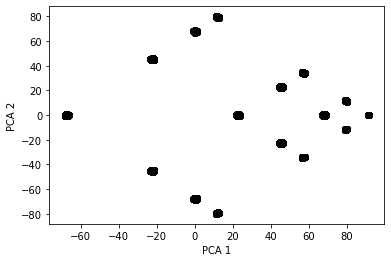

In [94]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

In [95]:
PCA_components.iloc[:,:3]

,0,1,2
0,91.747630,8.157135e-11,-11.494654
1,91.747630,6.183338e-11,-11.494654
2,91.747630,6.207046e-11,-11.494654
3,91.747630,6.211174e-11,-11.494654
4,91.747630,6.212052e-11,-11.494654
...,...,...,...
241595,-68.593443,-4.639109e-11,25.477561
241596,-68.593443,-4.639111e-11,25.477561
241597,-68.593443,-4.639110e-11,25.477561
241598,-68.593443,-4.639110e-11,25.477561


In [96]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(PCA_components.iloc[:,:3], y, test_size=0.2, random_state=1)

In [97]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)
print(y_train_enc.shape)

(193280, 2)


In [98]:
# define the model
#get number of columns in training data
n_cols=X_train_scaled.shape[1]

# define model 2 layers
model = Sequential()
model.add(Dense(100, input_dim=n_cols, activation='relu'))
model.add(Dense(50,  activation='relu'))
model.add(Dense(2, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [99]:
epochs= 200
start=time.time()
#fit model
hist=model.fit(X_train_scaled, y_train_enc,  validation_split=0.2, epochs=epochs,batch_size=100, verbose=1)
end=time.time()
print("Elapsed Time: ", end-start)

Train on 154624 samples, validate on 38656 samples
Epoch 1/200
154624/154624 [==============================] - 3s 20us/step - loss: 0.3772 - accuracy: 0.8241 - val_loss: 0.3634 - val_accuracy: 0.8295
Epoch 2/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.3611 - accuracy: 0.8302 - val_loss: 0.3531 - val_accuracy: 0.8310
Epoch 3/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.3493 - accuracy: 0.8356 - val_loss: 0.3395 - val_accuracy: 0.8428
Epoch 4/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.3407 - accuracy: 0.8406 - val_loss: 0.3327 - val_accuracy: 0.8462
Epoch 5/200
154624/154624 [==============================] - 3s 20us/step - loss: 0.3361 - accuracy: 0.8421 - val_loss: 0.3300 - val_accuracy: 0.8492
Epoch 6/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.3324 - accuracy: 0.8432 - val_loss: 0.3267 - val_accuracy: 0.8452
Epoch 7/200
154624/154624 [======================

Epoch 55/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.2664 - accuracy: 0.8604 - val_loss: 0.2668 - val_accuracy: 0.8580
Epoch 56/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.2648 - accuracy: 0.8614 - val_loss: 0.2639 - val_accuracy: 0.8684
Epoch 57/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.2643 - accuracy: 0.8615 - val_loss: 0.2589 - val_accuracy: 0.8616
Epoch 58/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.2641 - accuracy: 0.8618 - val_loss: 0.2652 - val_accuracy: 0.8532
Epoch 59/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.2635 - accuracy: 0.8625 - val_loss: 0.2702 - val_accuracy: 0.8585
Epoch 60/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.2619 - accuracy: 0.8638 - val_loss: 0.2547 - val_accuracy: 0.8625
Epoch 61/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.2619 - ac

154624/154624 [==============================] - 3s 19us/step - loss: 0.2440 - accuracy: 0.8697 - val_loss: 0.2389 - val_accuracy: 0.8742
Epoch 110/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.2424 - accuracy: 0.8710 - val_loss: 0.2455 - val_accuracy: 0.8680
Epoch 111/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.2427 - accuracy: 0.8706 - val_loss: 0.2425 - val_accuracy: 0.8702
Epoch 112/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.2427 - accuracy: 0.8708 - val_loss: 0.2369 - val_accuracy: 0.8673
Epoch 113/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.2423 - accuracy: 0.8702 - val_loss: 0.2385 - val_accuracy: 0.8641
Epoch 114/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.2429 - accuracy: 0.8709 - val_loss: 0.2429 - val_accuracy: 0.8727
Epoch 115/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.2411 - accuracy:

Epoch 163/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.2370 - accuracy: 0.8743 - val_loss: 0.2328 - val_accuracy: 0.8748
Epoch 164/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.2369 - accuracy: 0.8745 - val_loss: 0.2326 - val_accuracy: 0.8748
Epoch 165/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.2369 - accuracy: 0.8731 - val_loss: 0.2305 - val_accuracy: 0.8775
Epoch 166/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.2367 - accuracy: 0.8743 - val_loss: 0.2348 - val_accuracy: 0.8759
Epoch 167/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.2367 - accuracy: 0.8745 - val_loss: 0.2315 - val_accuracy: 0.8687
Epoch 168/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.2373 - accuracy: 0.8741 - val_loss: 0.2314 - val_accuracy: 0.8734
Epoch 169/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.23

In [100]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_scaled, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_scaled, verbose=1)

48320/48320 [==============================] - 1s 12us/step


In [101]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.877359
Precision: 0.816870
Recall: 0.684806
F1 score: 0.745031


In [102]:


# ROC AUC
auc = roc_auc_score(y_test_enc, yhat_probs)
print('ROC AUC: %f' % auc)

ROC AUC: 0.953914


In [103]:
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

[[33736  1941]
 [ 3985  8658]]


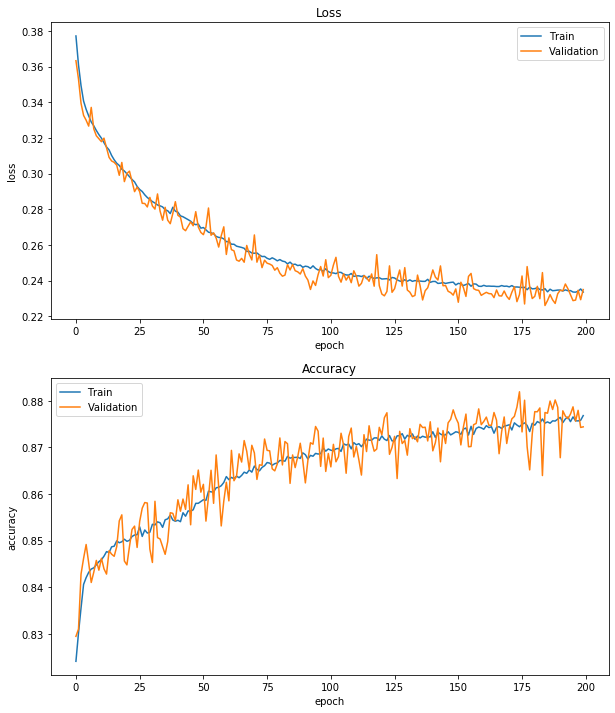

In [107]:
# plot loss during training
plt.figure(1, figsize=(10,12))
plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# RCA

In [108]:
rca = GaussianRandomProjection(n_components=2, eps=0.1, random_state=42)
X_rca=rca.fit_transform(X)

In [109]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_rca, y, test_size=0.2, random_state=1)

In [110]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)
print(y_train_enc.shape)

(193280, 2)


In [111]:
# define the model
#get number of columns in training data
n_cols=X_train_scaled.shape[1]

# define model 3 layers
model = Sequential()
model.add(Dense(100, input_dim=n_cols, activation='relu'))
model.add(Dense(50,  activation='relu'))
model.add(Dense(2, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [112]:

epochs= 200
start=time.time()
#fit model
hist=model.fit(X_train_scaled, y_train_enc,  validation_split=0.2, epochs=epochs,batch_size=100, verbose=1)
end=time.time()
print("Elapsed Time: ", end-start)

Train on 154624 samples, validate on 38656 samples
Epoch 1/200
154624/154624 [==============================] - 3s 20us/step - loss: 0.5126 - accuracy: 0.7616 - val_loss: 0.4697 - val_accuracy: 0.7735
Epoch 2/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4604 - accuracy: 0.7773 - val_loss: 0.4414 - val_accuracy: 0.7867
Epoch 3/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4531 - accuracy: 0.7783 - val_loss: 0.4588 - val_accuracy: 0.7700
Epoch 4/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4505 - accuracy: 0.7802 - val_loss: 0.4346 - val_accuracy: 0.7914
Epoch 5/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4461 - accuracy: 0.7821 - val_loss: 0.4444 - val_accuracy: 0.7816
Epoch 6/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4441 - accuracy: 0.7826 - val_loss: 0.4736 - val_accuracy: 0.7601
Epoch 7/200
154624/154624 [======================

Epoch 55/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4216 - accuracy: 0.7915 - val_loss: 0.4211 - val_accuracy: 0.7964
Epoch 56/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4198 - accuracy: 0.7911 - val_loss: 0.4174 - val_accuracy: 0.7924
Epoch 57/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4200 - accuracy: 0.7919 - val_loss: 0.4158 - val_accuracy: 0.7945
Epoch 58/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4195 - accuracy: 0.7921 - val_loss: 0.4174 - val_accuracy: 0.7940
Epoch 59/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4188 - accuracy: 0.7923 - val_loss: 0.4346 - val_accuracy: 0.7874
Epoch 60/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4192 - accuracy: 0.7915 - val_loss: 0.4152 - val_accuracy: 0.7965
Epoch 61/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4184 - ac

154624/154624 [==============================] - 3s 19us/step - loss: 0.4131 - accuracy: 0.7928 - val_loss: 0.4177 - val_accuracy: 0.7952
Epoch 110/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4123 - accuracy: 0.7940 - val_loss: 0.4086 - val_accuracy: 0.7980
Epoch 111/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4122 - accuracy: 0.7943 - val_loss: 0.4077 - val_accuracy: 0.7990
Epoch 112/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4121 - accuracy: 0.7939 - val_loss: 0.4098 - val_accuracy: 0.7958
Epoch 113/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4117 - accuracy: 0.7945 - val_loss: 0.4076 - val_accuracy: 0.7983
Epoch 114/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4124 - accuracy: 0.7940 - val_loss: 0.4151 - val_accuracy: 0.8003
Epoch 115/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4130 - accuracy:

Epoch 163/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4108 - accuracy: 0.7949 - val_loss: 0.4094 - val_accuracy: 0.7968
Epoch 164/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4097 - accuracy: 0.7955 - val_loss: 0.4058 - val_accuracy: 0.7979
Epoch 165/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4101 - accuracy: 0.7961 - val_loss: 0.4110 - val_accuracy: 0.7923
Epoch 166/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4100 - accuracy: 0.7963 - val_loss: 0.4096 - val_accuracy: 0.7992
Epoch 167/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4101 - accuracy: 0.7957 - val_loss: 0.4079 - val_accuracy: 0.8001
Epoch 168/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4099 - accuracy: 0.7951 - val_loss: 0.4191 - val_accuracy: 0.7935
Epoch 169/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.41

In [113]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_scaled, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_scaled, verbose=1)

48320/48320 [==============================] - 0s 10us/step


In [114]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.798675
Precision: 0.670727
Recall: 0.452899
F1 score: 0.540699


In [115]:
# ROC AUC
auc = roc_auc_score(y_test_enc, yhat_probs)
print('ROC AUC: %f' % auc)


# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

ROC AUC: 0.842686
[[32866  2811]
 [ 6917  5726]]


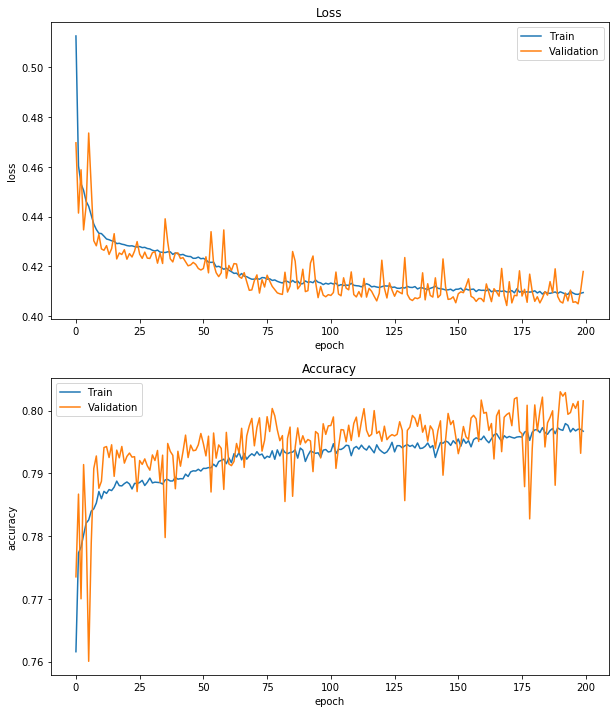

In [116]:
# plot loss during training
plt.figure(1, figsize=(10,12))
plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Feature Selection - Random Forest

In [117]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [118]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [119]:
boolvec=sel.get_support()
boolvec.astype(bool)
boolvec

array([ True,  True, False,  True,  True, False, False, False, False,
       False, False, False, False, False])

In [120]:
input_file=sgemm_df.iloc[:,0:14]
#X_RF=input_file.loc[:, sel.get_support()]
#input_file=sgemm_df.loc[:, sel.get_support()].head()
selected_feat= input_file.columns[(sel.get_support())]
#selected_feat = np.where(boolvec[:,None], X_train,X_train)
len(selected_feat)

4

In [121]:
print(selected_feat)
#sgemm_df

Index(['MWG', 'NWG', 'MDIMC', 'NDIMC'], dtype='object')


In [122]:
X_RF=input_file.loc[:, sel.get_support()]

In [123]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_RF, y, test_size=0.2, random_state=1)


In [124]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)
print(y_train_enc.shape)

(193280, 2)


In [125]:
# define the model
#get number of columns in training data
n_cols=X_train_scaled.shape[1]

# define model 3 layers
model = Sequential()
model.add(Dense(100, input_dim=n_cols, activation='relu'))
model.add(Dense(50,  activation='relu'))
model.add(Dense(2, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [126]:
epochs= 200
start=time.time()
#fit model
hist=model.fit(X_train_scaled, y_train_enc,  validation_split=0.2, epochs=epochs,batch_size=100, verbose=1)
end=time.time()
print("Elapsed Time: ", end-start)

Train on 154624 samples, validate on 38656 samples
Epoch 1/200
154624/154624 [==============================] - 3s 21us/step - loss: 0.2224 - accuracy: 0.8873 - val_loss: 0.1850 - val_accuracy: 0.8967
Epoch 2/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.1907 - accuracy: 0.8930 - val_loss: 0.1804 - val_accuracy: 0.8976
Epoch 3/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.1867 - accuracy: 0.8929 - val_loss: 0.1801 - val_accuracy: 0.8969
Epoch 4/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.1830 - accuracy: 0.8930 - val_loss: 0.1780 - val_accuracy: 0.8955
Epoch 5/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.1806 - accuracy: 0.8929 - val_loss: 0.1759 - val_accuracy: 0.8950
Epoch 6/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.1799 - accuracy: 0.8929 - val_loss: 0.1723 - val_accuracy: 0.8973
Epoch 7/200
154624/154624 [======================

Epoch 55/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.1694 - accuracy: 0.8981 - val_loss: 0.1680 - val_accuracy: 0.8972
Epoch 56/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.1696 - accuracy: 0.8979 - val_loss: 0.1680 - val_accuracy: 0.8986
Epoch 57/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.1693 - accuracy: 0.8983 - val_loss: 0.1682 - val_accuracy: 0.8972
Epoch 58/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.1696 - accuracy: 0.8980 - val_loss: 0.1677 - val_accuracy: 0.8988
Epoch 59/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.1694 - accuracy: 0.8983 - val_loss: 0.1677 - val_accuracy: 0.8972
Epoch 60/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.1693 - accuracy: 0.8983 - val_loss: 0.1674 - val_accuracy: 0.8995
Epoch 61/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.1695 - ac

154624/154624 [==============================] - 3s 19us/step - loss: 0.1692 - accuracy: 0.8984 - val_loss: 0.1676 - val_accuracy: 0.8986
Epoch 110/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.1692 - accuracy: 0.8979 - val_loss: 0.1680 - val_accuracy: 0.8988
Epoch 111/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.1693 - accuracy: 0.8984 - val_loss: 0.1679 - val_accuracy: 0.8988
Epoch 112/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.1692 - accuracy: 0.8983 - val_loss: 0.1678 - val_accuracy: 0.8966
Epoch 113/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.1693 - accuracy: 0.8978 - val_loss: 0.1681 - val_accuracy: 0.8981
Epoch 114/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.1693 - accuracy: 0.8985 - val_loss: 0.1677 - val_accuracy: 0.8986
Epoch 115/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.1693 - accuracy:

Epoch 163/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.1695 - accuracy: 0.8981 - val_loss: 0.1680 - val_accuracy: 0.8988
Epoch 164/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.1695 - accuracy: 0.8979 - val_loss: 0.1680 - val_accuracy: 0.8988
Epoch 165/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.1701 - accuracy: 0.8969 - val_loss: 0.1681 - val_accuracy: 0.8966
Epoch 166/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.1695 - accuracy: 0.8968 - val_loss: 0.1676 - val_accuracy: 0.8966
Epoch 167/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.1695 - accuracy: 0.8971 - val_loss: 0.1680 - val_accuracy: 0.8988
Epoch 168/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.1692 - accuracy: 0.8982 - val_loss: 0.1677 - val_accuracy: 0.8988
Epoch 169/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.16

In [127]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_scaled, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_scaled, verbose=1)

48320/48320 [==============================] - 0s 10us/step


In [128]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.900497
Precision: 0.869123
Recall: 0.729574
F1 score: 0.793258


In [129]:
# ROC AUC
auc = roc_auc_score(y_test_enc, yhat_probs)
print('ROC AUC: %f' % auc)


# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

ROC AUC: 0.971188
[[34288  1389]
 [ 3419  9224]]


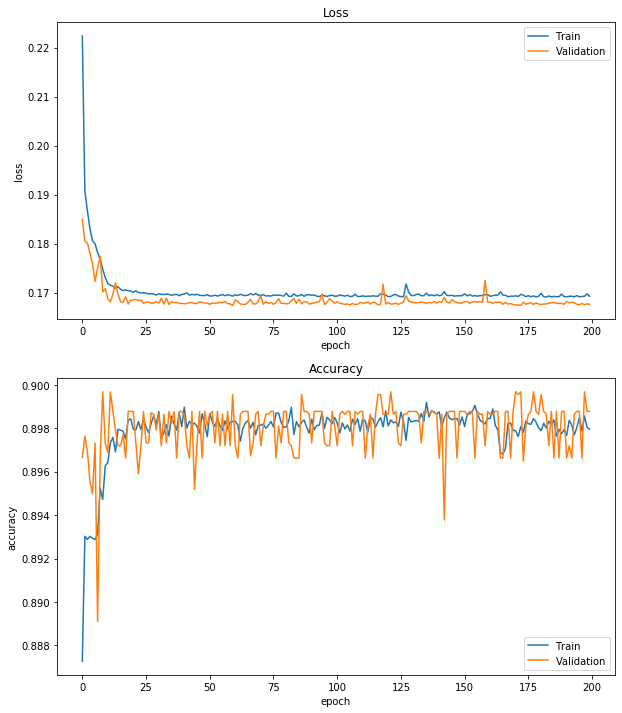

In [130]:
# plot loss during training
plt.figure(1, figsize=(10,12))
plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# ICA

In [131]:
ICA = FastICA(n_components=2, random_state=42) 
X_ica=ICA.fit_transform(X)

In [132]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_ica, y, test_size=0.2, random_state=1)

In [133]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)
print(y_train_enc.shape)

(193280, 2)


In [134]:
# define the model
#get number of columns in training data
n_cols=X_train_scaled.shape[1]

# define model 3 layers
model = Sequential()
model.add(Dense(100, input_dim=n_cols, activation='relu'))
model.add(Dense(50,  activation='relu'))
model.add(Dense(2, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [135]:
epochs= 200
start=time.time()
#fit model
hist=model.fit(X_train_scaled, y_train_enc,  validation_split=0.2, epochs=epochs,batch_size=100, verbose=1)
end=time.time()
print("Elapsed Time: ", end-start)

Train on 154624 samples, validate on 38656 samples
Epoch 1/200
154624/154624 [==============================] - 3s 20us/step - loss: 0.5282 - accuracy: 0.7527 - val_loss: 0.4235 - val_accuracy: 0.8050
Epoch 2/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.4001 - accuracy: 0.8118 - val_loss: 0.3936 - val_accuracy: 0.8149
Epoch 3/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.3985 - accuracy: 0.8117 - val_loss: 0.3946 - val_accuracy: 0.8149
Epoch 4/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.3979 - accuracy: 0.8121 - val_loss: 0.3931 - val_accuracy: 0.8149
Epoch 5/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.3980 - accuracy: 0.8113 - val_loss: 0.3951 - val_accuracy: 0.8149
Epoch 6/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.3966 - accuracy: 0.8122 - val_loss: 0.3920 - val_accuracy: 0.8149
Epoch 7/200
154624/154624 [======================

Epoch 55/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.3917 - accuracy: 0.8129 - val_loss: 0.3869 - val_accuracy: 0.8149
Epoch 56/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.3916 - accuracy: 0.8131 - val_loss: 0.3923 - val_accuracy: 0.8149
Epoch 57/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.3916 - accuracy: 0.8131 - val_loss: 0.3870 - val_accuracy: 0.8149
Epoch 58/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.3916 - accuracy: 0.8129 - val_loss: 0.3946 - val_accuracy: 0.8149
Epoch 59/200
154624/154624 [==============================] - 3s 20us/step - loss: 0.3915 - accuracy: 0.8129 - val_loss: 0.3872 - val_accuracy: 0.8149
Epoch 60/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.3914 - accuracy: 0.8130 - val_loss: 0.3894 - val_accuracy: 0.8149
Epoch 61/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.3918 - ac

154624/154624 [==============================] - 3s 18us/step - loss: 0.3910 - accuracy: 0.8131 - val_loss: 0.3864 - val_accuracy: 0.8149
Epoch 110/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.3908 - accuracy: 0.8131 - val_loss: 0.3885 - val_accuracy: 0.8149
Epoch 111/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.3909 - accuracy: 0.8130 - val_loss: 0.3870 - val_accuracy: 0.8149
Epoch 112/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.3907 - accuracy: 0.8131 - val_loss: 0.3874 - val_accuracy: 0.8149
Epoch 113/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.3908 - accuracy: 0.8131 - val_loss: 0.3861 - val_accuracy: 0.8149
Epoch 114/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.3909 - accuracy: 0.8129 - val_loss: 0.3873 - val_accuracy: 0.8149
Epoch 115/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.3908 - accuracy:

Epoch 163/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.3906 - accuracy: 0.8131 - val_loss: 0.3875 - val_accuracy: 0.8149
Epoch 164/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.3905 - accuracy: 0.8130 - val_loss: 0.3877 - val_accuracy: 0.8149
Epoch 165/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.3906 - accuracy: 0.8130 - val_loss: 0.3865 - val_accuracy: 0.8149
Epoch 166/200
154624/154624 [==============================] - 3s 19us/step - loss: 0.3905 - accuracy: 0.8131 - val_loss: 0.3878 - val_accuracy: 0.8149
Epoch 167/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.3905 - accuracy: 0.8131 - val_loss: 0.3860 - val_accuracy: 0.8149
Epoch 168/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.3907 - accuracy: 0.8131 - val_loss: 0.3857 - val_accuracy: 0.8149
Epoch 169/200
154624/154624 [==============================] - 3s 18us/step - loss: 0.39

In [136]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_scaled, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_scaled, verbose=1)

48320/48320 [==============================] - 0s 10us/step


In [137]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)


Accuracy: 0.812562
Precision: 0.713047
Recall: 0.474650
F1 score: 0.569923


In [138]:
# ROC AUC
auc = roc_auc_score(y_test_enc, yhat_probs)
print('ROC AUC: %f' % auc)


# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

ROC AUC: 0.854319
[[33262  2415]
 [ 6642  6001]]


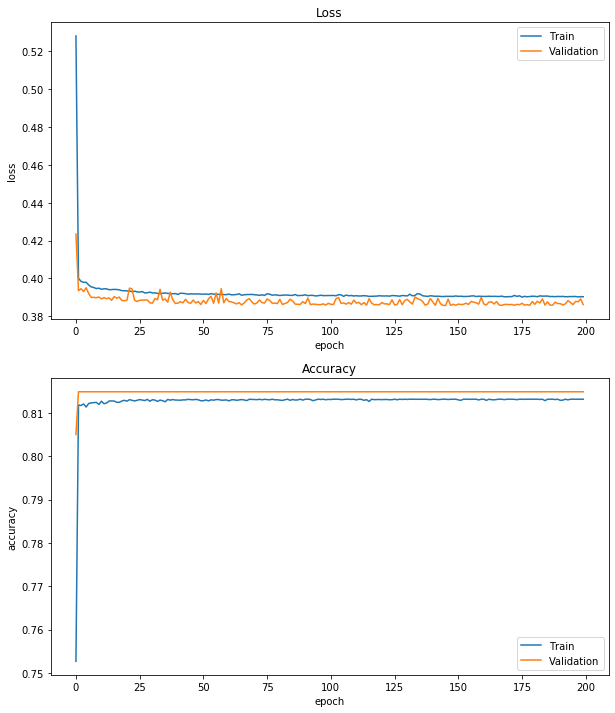

In [139]:
# plot loss during training
plt.figure(1, figsize=(10,12))
plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()